In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats

%matplotlib inline

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
## simulation avec de l'aléatoire
def lotka_volterra(mu_alpha = 0.5, sigma_alpha = 0.2, mu_beta = 0.05, sigma_beta = 0.02,
                   mu_delta = 0.05, sigma_delta = 0.02, mu_gamma = 0.5, sigma_gamma = 0.2, 
                   lambda_y0 = np.log(10), zeta_y0 = 1, lambda_z0 = np.log(10), zeta_z0 = 1, 
                   t0 = 1900, tf = 1920, dt = 0.01,
                   sample_size = 1):
    
    alpha = np.random.lognormal(mu_alpha, sigma_alpha, size = sample_size)
    beta = np.random.lognormal(mu_beta, sigma_beta, size = sample_size)
    delta = np.random.lognormal(mu_delta, sigma_delta, size = sample_size)
    gamma = np.random.lognormal(mu_gamma, sigma_gamma, size = sample_size)
    y0 = np.random.lognormal(lambda_y0, zeta_y0, size = sample_size)
    z0 = np.random.lognormal(lambda_y0, zeta_z0, size = sample_size)

    proie = [y0]
    pred = [z0]
    times = [t0]
    t = t0
    while t < tf:
        t += dt
        times.append(t)
        proie.append(proie[-1] + dt * proie[-1]*(alpha - beta*pred[-1]))
        pred.append(pred[-1] + dt * pred[-1]*(delta*proie[-1] - gamma))
   
    return proie, pred, times
    

In [3]:
# résolution explicite
def lotka_volterra_opt(x, 
                   t0 = 1900, tf = 1920, dt = 0.01,
                   sample_size = 1):
    alpha = x[0]
    beta = x[1]
    delta = x[2]
    gamma = x[3]
    y0 = x[4]
    z0 = x[5]
    
    proie = [y0]
    pred = [z0]
    times = [t0]
    t = t0
    while t < tf:
        t += dt
        times.append(t)
        proie.append(proie[-1] + dt * proie[-1]*(alpha - beta*pred[-1]))
        pred.append(pred[-1] + dt * pred[-1]*(delta*proie[-1] - gamma))
   
    return proie, pred, times
    

### Exemple de simulation

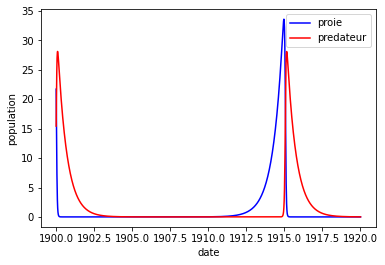

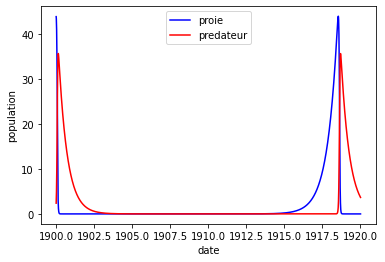

In [4]:
proie, pred, times = lotka_volterra(dt = 0.01, tf = 1920, sample_size=2)
plt.figure()
plt.plot(times, np.array(proie)[:,0], color ='b')
plt.plot(times, np.array(pred)[:,0], color = 'r')
plt.legend(['proie', 'predateur'], loc='best')
plt.xlabel('date')
plt.ylabel('population')
plt.show()

plt.figure()
plt.plot(times, np.array(proie)[:,1], color ='b')
plt.plot(times, np.array(pred)[:,1], color = 'r')
plt.legend(['proie', 'predateur'], loc='best')
plt.xlabel('date')
plt.ylabel('population')
plt.show()

### Fonction de répartition

Etant données les v.a. $X_1, \cdots, X_n$, définissons la fonction de répartition empirique sur $\mathbb{R}$ 
$$
F_n(x) := \frac 1 n \sum_{i=1}^n 1_{X_i\leq x}, \qquad  x \in \mathbb{R};
$$
et les statistiques d'ordre associées $(X_{(i,n)})_{1\leq i\leq n}$ : 
$$
X_{(1,n)} \leq X_{(2,n)} \leq \cdots \leq X_{(i,n)} \leq \cdots \leq X_{(n,n)}.
$$
À noter que ces inégalités sont strictes avec probabilité $1$ puisque les v.a. sont i.i.d. sous une loi à densité. 


***
Nous avons aussi 
$$
F_n(x) := \frac 1 n \sum_{i=1}^n 1_{X_{(i,n)}\leq x}, \qquad  x \in \mathbb{R}.
$$
À partir de la définition des $X_{(i,n)}$, pour $0 \leq x \leq 1$:
$$
F_n(x)= \left\{ \begin{array}{ll}
0 & \mbox{ si } x < X_{(1,n)}
\\
\frac i n & \mbox{ si } \quad X_{(i,n)} \leq x < X_{(i+1,n)}
\\
1 & \mbox{ si } x \ge X_{(n,n)}
\end{array} \right.
$$
***

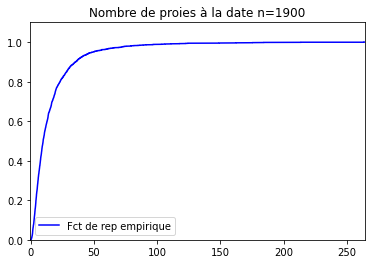

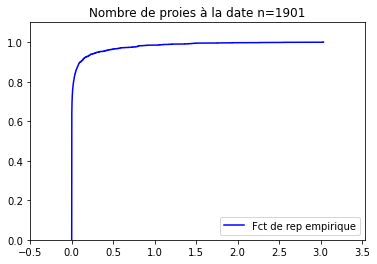

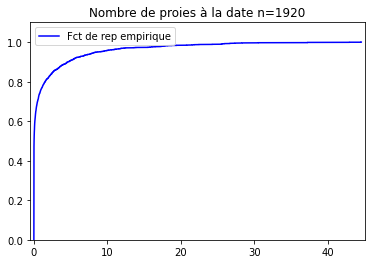

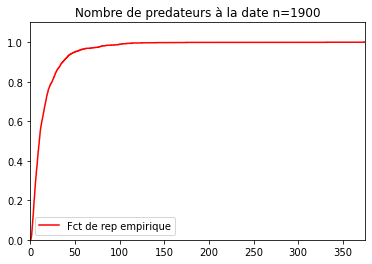

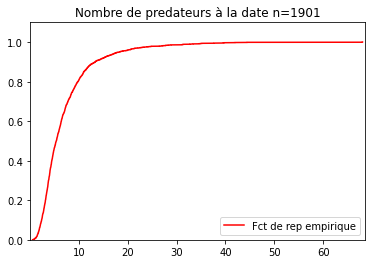

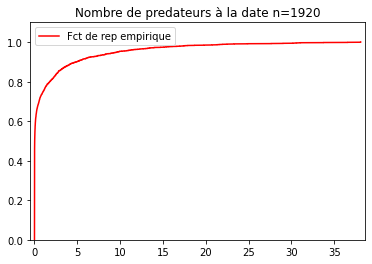

In [5]:
n = 2000
proie, pred, times = lotka_volterra(dt = 0.001, tf = 1920, sample_size=n)

for i in [0, 1, 20]:
    X = np.array(proie)[i*1000,:] #dt = 0.001 pour éviter la divergence de la solution
    x = np.linspace(min(X), max(X), 100)

    #Fct de repartition empirique 
    X.sort(axis = 0)   
    F_x_n = np.arange(1, n+1) / n   #attention au dernier point
    plt.step(X, F_x_n, "b", where="post", label="Fct de rep empirique") 
    plt.title('Nombre de proies à la date n=%1.0f' %(1900+i))
    plt.axis([x[0]-0.5, x[-1]+0.5, 0, 1.1])
    plt.legend(loc='best')
    plt.show()

for i in [0, 1, 20]:
    X = np.array(pred)[i*1000,:]
    x = np.linspace(min(X), max(X), 100)

    #Fct de repartition empirique 
    X.sort(axis = 0)   
    F_x_n = np.arange(1, n+1) / n   #attention au dernier point
    plt.step(X, F_x_n, "r", where="post", label="Fct de rep empirique") 
    plt.title('Nombre de predateurs à la date n=%1.0f' %(1900+i))
    plt.axis([x[0]-0.5, x[-1]+0.5, 0, 1.1])
    plt.legend(loc='best')
    plt.show()


***
***
### Estimation de la densité
***

Dorénavant, on considère une suite $(X_i)_{i\ge 1}$ de aléatoires i.i.d. dont on suppose qu'elles ont une densité $f$ sur $\mathbb{R}$. Afin d'estimer $f$, pour chaque valeur de $n$, on va construire, à partir des observations $X_1, \ldots, X_n$, une densité $f_n$.
Cette densité pourra, selon la stratégie choisie, être construite via différents procédés, et on verra dans quelle mesure, pour $x\in \mathbb{R}$,
$$
f_n(x)\underset{n\to\infty}{\longrightarrow} f(x).
$$

(2002, 2000)
sig : 22.384303571105725
N : 1525


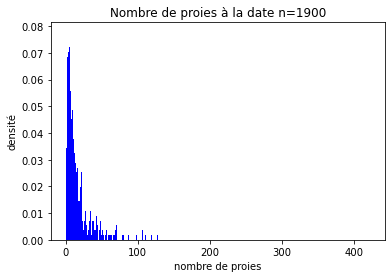

sig : 0.21833073442312054
N : 15


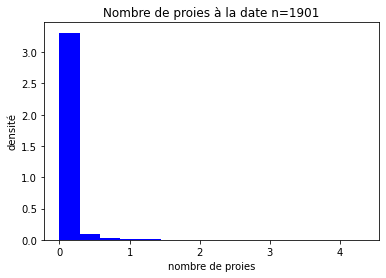

sig : 4.404617561010959
N : 181


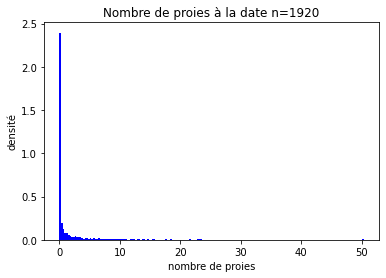

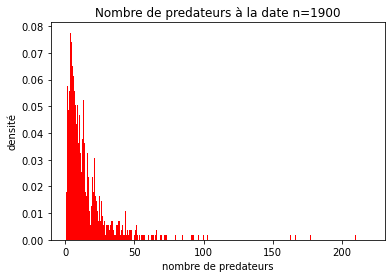

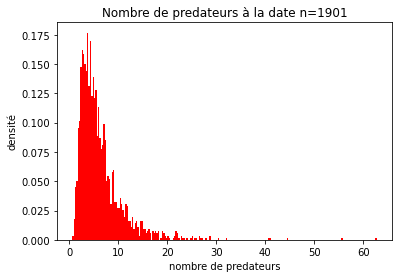

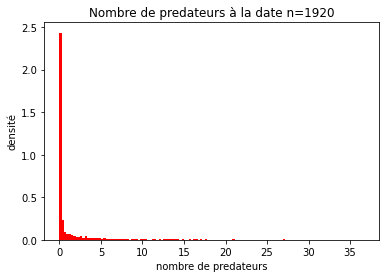

In [6]:
n = 2000

proie, pred, times = lotka_volterra(dt = 0.01, tf = 1920, sample_size=n)
print(np.array(proie).shape)
for i in [0, 1, 20]:
    X = np.array(proie)[i*100,:] #100 = 1/dt
    MinX, MaxX = min(X), max(X)
    sig = np.std(X)
    print("sig :",sig)
    L = MaxX - MinX
    N = int(n**(1./3.)*L/(3.49))
    print("N :",N)
    plt.hist(X, bins = N, density = True, color ='b')
    plt.xlabel('nombre de proies')
    plt.ylabel('densité')
    plt.title('Nombre de proies à la date n=%1.0f' %(1900+i))
    plt.show()
    
for i in [0, 1, 20]:
    plt.subplot()
    X = np.array(pred)[i*100,:] #100 = 1/dt
    MinX, MaxX = min(X), max(X)
    sig = np.std(X)
    L = MaxX - MinX
    N = int(n**(1./3.)*L/(3.49))
    plt.hist(X, bins = N, density = True, color ='r')
    plt.xlabel('nombre de predateurs')
    plt.ylabel('densité')
    plt.title('Nombre de predateurs à la date n=%1.0f' %(1900+i))
    plt.show()

#### Commentaires ####


$\blacktriangle$ La question du choix optimal pour la largeur des colonnes (ou des fenêtres) est délicate, notamment car sa réponse dépend fortement de l'information disponible quant à la densité $f$ à approcher.
Dans l'article [Scott 79](https://www.jstor.org/stable/2335182?seq=1#metadata_info_tab_contents), il est suggéré d'utiliser une largeur de colonne égale à $a \, \sigma_n  \, n^{-1/3}$, où $a=3.49$, $\sigma_n$ est l'écart-type  de l'échantillon et $n$ est la taille de l'échantillon  (dans le cas de la densité gaussienne, ce choix minimise une erreur quadratique). Cela signifie que si notre échantillon s'étale sur un intervalle de longueur $L$, notre histogramme devra avoir $N\approx \frac{n^{1/3}L}{a \, \sigma_n}$ colonnes. Illustrer cette affirmation avec des simulations  de variables aléatoires i.i.d. suivant diverses lois.

## Question 3

In [7]:
annee = [1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913,
1914, 1915, 1916, 1917, 1918, 1919, 1920]
lievre = [30, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22, 25.4, 27.1, 40.3, 57, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7]
lynx = [4, 6.1, 9.8, 35.2, 59.4, 41.7, 19, 13, 8.3, 9.1, 7.4, 8, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]

lievre = np.array(lievre)
lynx = np.array(lynx)

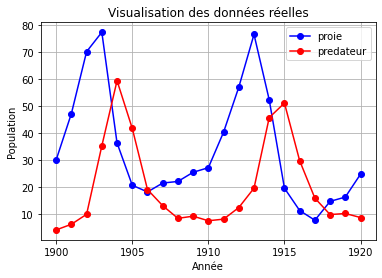

In [8]:
plt.figure()
plt.plot(annee, lievre, color ='b', marker = 'o')
plt.plot(annee, lynx, color = 'r', marker = 'o')
plt.legend(['proie', 'predateur'], loc='best')
plt.xlabel('Année')
plt.ylabel('Population')
plt.xticks(np.arange(1900, 1921, 5))
plt.grid()
plt.title('Visualisation des données réelles')
plt.show()

## Question 4

In [9]:
def e_proie(x, an = 1900):
    proie, pred, times = lotka_volterra_opt(x, dt = 0.001, tf = 1920, sample_size=2000)
    proie = np.array(proie)
    return np.log(proie[1000*(an-1900)]) - np.log(lievre[an-1900])

In [10]:
def e_pred(x, an = 1900):
    proie, pred, times = lotka_volterra_opt(x, dt = 0.001, tf = 1920, sample_size=2000)
    pred = np.array(pred)
    return np.log(pred[1000*(an-1900)]) - np.log(lynx[an-1900])

In [11]:
def epsilon(x):
    return np.sum([e_proie(x, an)**2 + e_pred(x, an)**2 for an in np.arange(1900, 1921, 1)])

In [12]:
def convert(mu, var):
    return np.log(mu ** 2 / np.sqrt(var + mu ** 2)), np.log(var / mu ** 2 + 1)

In [13]:
# Fonction permettant de calibrer notre modèle sur les données réelles
def get_opt(lievre = lievre, lynx = lynx):

    mean_alpha , var_a = convert(0.5, 0.2**2)           # Moyenne, et variance du paramètre alpha
    mean_beta , var_b = convert(0.05, 0.02**2)          # Moyenne, et variance du paramètre beta
    mean_delta , var_d = convert(0.05, 0.02**2)         # Moyenne, et variance du paramètre delta
    mean_gamma , var_g = convert(0.5, 0.2**2)           # Moyenne, et variance du paramètre gamma
    mean_y0 , var_y0 = np.log(10), 1                    # Moyenne, et variance du paramètre y_0
    mean_z0 , var_z0 = np.log(10), 1                    # Moyenne, et variance du paramètre z_0

    # Listes des moyennes, variances
    means = np.array([mean_alpha, mean_beta, mean_delta, mean_gamma, mean_y0, mean_z0])
    var = np.array([var_a, var_b, var_d, var_g, var_y0, var_z0])
    std = np.sqrt(var)
    
    left = np.exp(means - 2*std)
    right = np.exp(means + 2*std)
    bounds = [(left[i],right[i]) for i in range(6)]
    
    eps_values = []
    x0 = []
    
    for p in range(6):
        x0.append(np.random.uniform(left[p], right[p]))
    result = minimize(epsilon, x0, bounds=bounds).x.reshape((6, 1))
    eps_values.append((result, epsilon(result)))
    eps_values.sort(key=lambda a:a[1])
    x_opt, err = eps_values[0]
    return x_opt, err

N = 1
x_opt, err = get_opt(lievre,lynx)
print(x_opt, err)

[[5.40201249e-01]
 [2.71635678e-02]
 [2.36959121e-02]
 [7.96338167e-01]
 [3.45993355e+01]
 [5.84492249e+00]] 2.0184690327994312


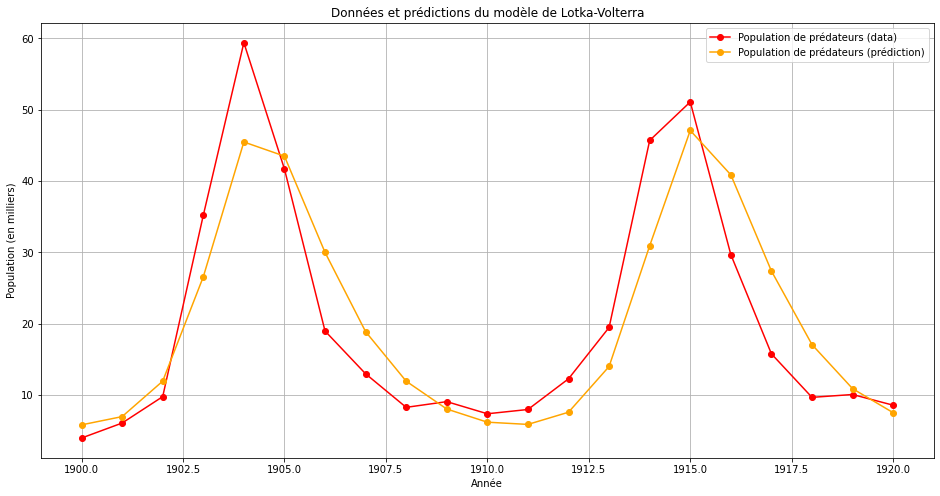

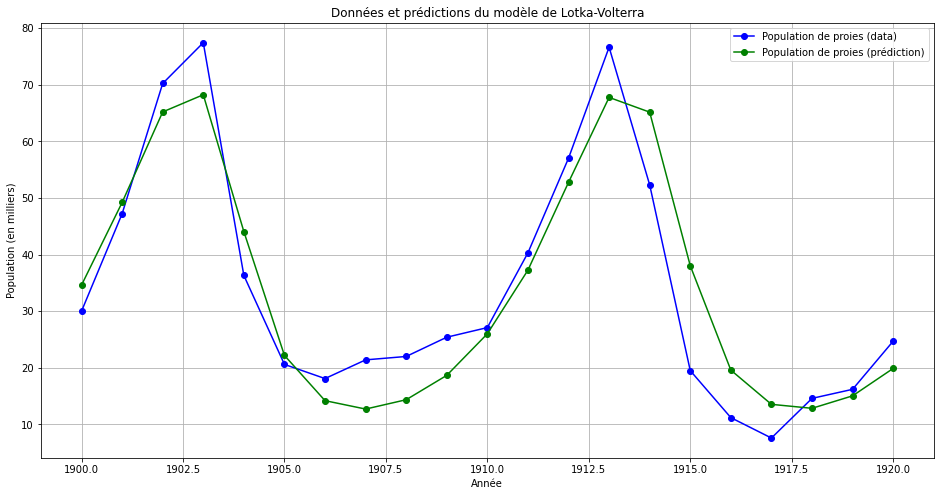

In [14]:
# Affichage des données et des prédictions
n = 2000

prediction_proie, prediction_pred, times = lotka_volterra_opt(x = x_opt, dt = 0.01, tf = 1920, sample_size=n)

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(annee, lynx, color = 'r', marker='o', label='Population de prédateurs (data)')
ax.plot(annee, [prediction_pred[i*len(prediction_pred)//21] for i in range(21)],color = 'orange', marker='o', label='Population de prédateurs (prédiction)')
ax.set_xlabel('Année')
ax.grid()
ax.set_ylabel('Population (en milliers)')
ax.set_title(f'Données et prédictions du modèle de Lotka-Volterra')
ax.legend()

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(annee, lievre, color = 'b', marker= 'o', label='Population de proies (data)')
ax.plot(annee, [prediction_proie[i*len(prediction_proie)//21] for i in range(21)], color='green', marker = 'o',label='Population de proies (prédiction)')
ax.set_xlabel('Année')
ax.grid()
ax.set_ylabel('Population (en milliers)')
ax.set_title(f'Données et prédictions du modèle de Lotka-Volterra')
ax.legend()
plt.show()

## Question 5

Par définition,
\begin{align}
p(data | x, \sigma) = \frac{1}{(2\pi)^{21} \sigma_{proie}^{21} \sigma_{preda}^{21}} exp \bigg[-\frac{1}{2} \sum_{i=0}^{20} \frac{e_{proie}(x, t_i)^2}{\sigma_{proie}^{2}} -\frac{1}{2} \sum_{i=0}^{20} \frac{e_{preda}(x, t_i)^2}{\sigma_{preda}^{2}} \bigg]
\end{align}

Minimiser la vraisemblance est équivalent à minimiser la log-vraisemblance, tout est strictement positif.

\begin{align}
L(\sigma_{proie}, \sigma_{preda}) = log(p(data | x, \sigma)) = g(\sigma_{proie}, e_{proie}) + g(\sigma_{preda}, e_{pred}) 
\end{align}

Où:
\begin{align}
g(\sigma, e) = -\frac{21}{2}(2\pi) - 21log(\sigma)-\frac{1}{2} \sum_{i=0}^{20} \frac{e(x, t_i)^2}{\sigma^{2}} 
\end{align}
Par symétrie du problème, il nous suffit de trouver le maximum de la fonction $g$ par rapport à la première variable.    

On calcule alors:

\begin{equation}
    \begin{cases}
      \nabla_{\sigma} f(\sigma, e) = \frac{-21}{\sigma} + \frac{1}{\sigma^{3}} \sum_{i=0}^{20} e(x, t_i)^2 \\
      \nabla_{\sigma}^2 f(\sigma, e) = -\frac{3}{\sigma^{4}} \sum_{i=0}^{20} e(x, t_i)^2 < 0
    \end{cases} 
\end{equation}

La dérivée seconde est strictement négative, donc la fonction g admet un maximum en $\sigma^*$ qui annule le gradient en sigma $\nabla_{\sigma^*} g(\sigma, e)=0$.    

Ainsi 
\begin{align}
(\sigma^*)^2 = \frac{1}{21} \sum_{i=0}^{20} e(x, t_i)^2
\end{align}

Par conséquent, on trouve:

\begin{equation}
    \begin{cases}
        (\sigma_{proie}^*)^2 = \frac{1}{21} \sum_{i=0}^{20} e_{proie}(x, t_i)^2 \\
        (\sigma_{pred}^*)^2 = \frac{1}{21} \sum_{i=0}^{20} e_{pred}(x, t_i)^2
    \end{cases}
\end{equation}

## Question 6

In [15]:
mean_alpha , var_a = convert(0.5, 0.2**2)           # Moyenne, et variance du paramètre alpha
mean_beta , var_b = convert(0.05, 0.02**2)          # Moyenne, et variance du paramètre beta
mean_delta , var_d = convert(0.05, 0.02**2)         # Moyenne, et variance du paramètre delta
mean_gamma , var_g = convert(0.5, 0.2**2)           # Moyenne, et variance du paramètre gamma
mean_y0 , var_y0 = np.log(10), 1                    # Moyenne, et variance du paramètre y_0
mean_z0 , var_z0 = np.log(10), 1                    # Moyenne, et variance du paramètre z_0
means = np.array([mean_alpha, mean_beta, mean_delta, mean_gamma, mean_y0, mean_z0])
var = np.array([var_a, var_b, var_d, var_g, var_y0, var_z0])
std = np.sqrt(var)

In [16]:
# Algorithme de metropolis Hastings
def metropolis_hastings(pp, n_samples, x_init, cov, sigma_param=False):
    
    dim = len(x_init)
    samples = np.zeros((n_samples, dim))
    x_curr = x_init
    n_prev = 0
    for i in range(n_samples):
        if  i > 0:
            cov = ((n_prev - 1) / n_prev) * np.cov(samples.T)
        x_prop = np.random.multivariate_normal(x_curr, cov)
        while is_neg(x_prop): 
            x_prop = np.random.multivariate_normal(x_curr, cov)
        if not sigma_param:
            alpha = min(1, pp(x_prop) / pp(x_curr))
        else:
            alpha = min(1, pp(x_prop[:-2], x_prop[-2:]) / pp(x_curr[:-2], x_curr[-2:]))
        u = np.random.uniform()
        if u < alpha:
            x_curr = x_prop
        samples[i] = x_curr
        n_prev += 1
    return samples
  
# Fonction qui implémente p(data| x, sigma*)
def p_sachant(x, sigma, lynx = lynx, lievre = lievre):
    x = x.reshape((6,1))
    y, z, _ = lotka_volterra_opt(x, dt = 0.001, tf = 1920, sample_size=2000)
    val_proie = e_proie(x, 1920)
    val_preda = e_pred(x, 1920)
    
    err = np.sum(val_proie**2)/sigma[0]**2 + np.sum(val_preda**2)/sigma[1]**2
    cte = 1 / (2 * np.pi * sigma[0] * sigma[1])
    
    result = (cte ** 21) * np.exp(-err/2)

    return result

# Fonction qui implémente p_prior(x)
def p_prior_x(x):
    s = 1
    for i in range(6):
        s *= scipy.stats.norm(means[i], std[i]).pdf(np.log(x[i])) /x[i]
    return s

# Valeur de sigma
def sigma(x, lynx = lynx, lievre = lievre):
    y, z, _ = lotka_volterra_opt(x, dt = 0.001, tf = 1920, sample_size=2000)
    val_proie = e_proie(x, 1920)
    val_preda = e_pred(x, 1920)
    sigma1 = np.sum(val_proie**2) / 21
    sigma2 = np.sum(val_preda**2) / 21
    return np.sqrt(sigma1), np.sqrt(sigma2)

sigma = sigma(x_opt, lievre, lynx)  

# Fonction qui implémente p(x|data,sigma) :
def p_post(x, proie=lievre, preda=lynx, sigma=sigma):
    return p_sachant(x, sigma, proie, preda) * p_prior_x(x)

# Fonction vérifie si l'une des cordonnées de x est négative
def is_neg(x):
    return False in (x>0)


In [17]:
# Simulation : 

echantillon_x = metropolis_hastings(p_post, n_samples=2000, x_init=x_opt.squeeze(), cov=np.diag(std))

In [19]:
params = [r'$\alpha$', r'$\beta$', r'$\delta$', r'$\gamma$']
colors = ['blue', 'red', 'green', 'yellow']

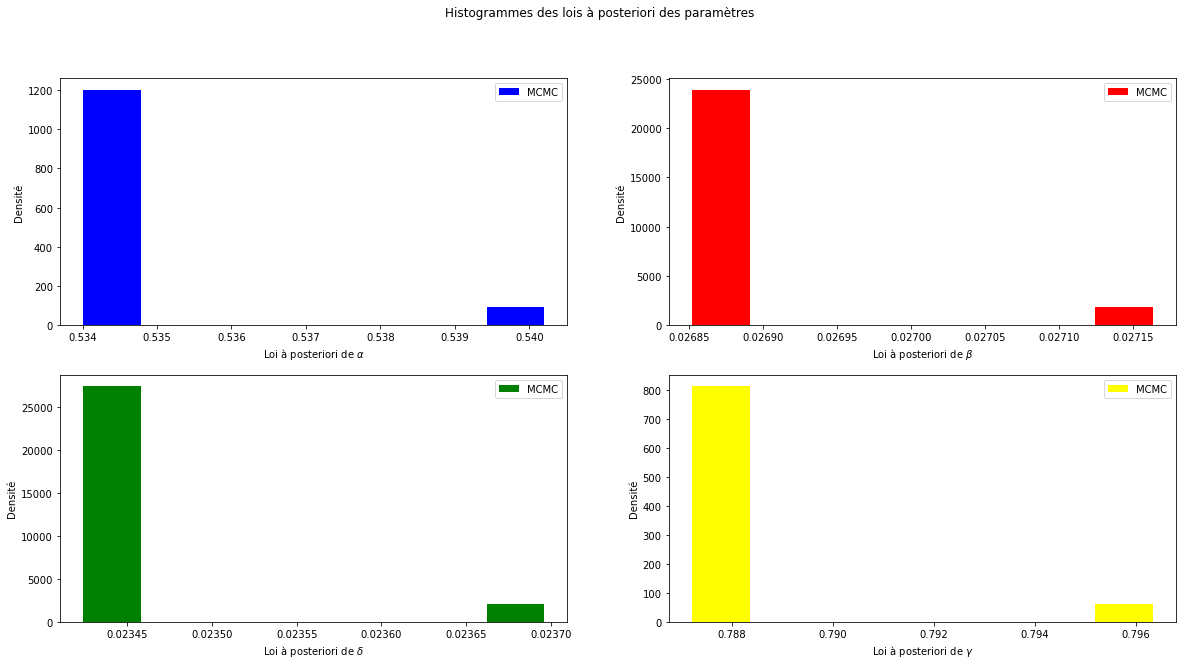

In [31]:
echantillon = echantillon_x[:70,:]
plt.figure(figsize=(20,10))
plt.suptitle("Histogrammes des lois à posteriori des paramètres")
for j in range(1, 5):
    plt.subplot(2, 2, j)
    plt.ylabel("Densité")
    plt.xlabel(f"Loi à posteriori de {params[j-1]}")
    n, bins, patches = plt.hist(echantillon[:, j-1], bins='auto', density=True, color=colors[j-1], label='MCMC')
    plt.legend(loc='best')

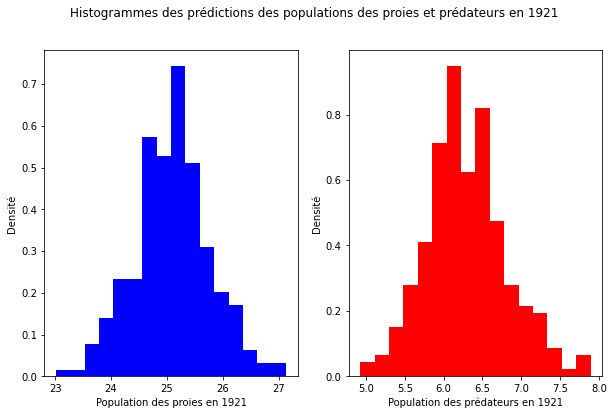

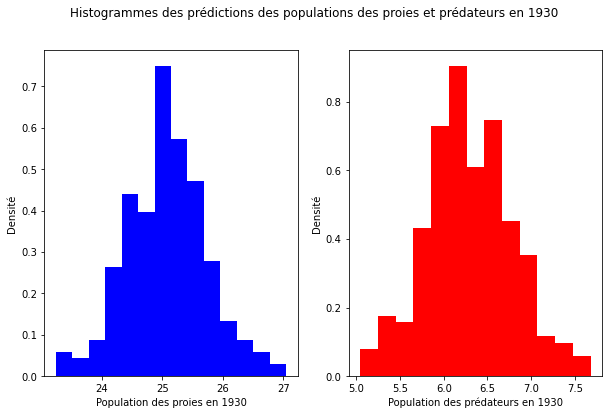

In [21]:
# Prédictions des populations de proies et prédateurs en 1921 et en 1930
# Simulation epsilon
t0 = 1900
# Calcul des prédiction pour les instants dans la listes dates
def prediction(dates):
    eps_proie = np.random.normal(0, sigma[0], size=(echantillon.shape[0],len(dates)))
    eps_preda = np.random.normal(0, sigma[1], size=(echantillon.shape[0],len(dates)))
    
    x = [echantillon[:,i] for i in range(6)]
    y, z, _ = lotka_volterra_opt(x, dt = 0.001, tf = 1920, sample_size=2000)
    y = np.array(y[-1])
    z = np.array(z[-1])
    
    return y[np.array(dates)-t0]*np.exp(eps_proie), z[np.array(dates)-t0]*np.exp(eps_preda)

dates = [1921, 1930]
proie, preda =  prediction(dates)
# Histogrammes 
#1921
plt.figure(figsize=(10,6))
plt.suptitle("Histogrammes des prédictions des populations des proies et prédateurs en 1921")
plt.subplot(1, 2, 1)
plt.ylabel("Densité")
plt.xlabel(f"Population des proies en 1921")
n, bins, patches = plt.hist(proie[:, 0], bins='auto', density=True, color='blue')
plt.subplot(1, 2, 2)
plt.ylabel("Densité")
plt.xlabel(f"Population des prédateurs en 1921")
n, bins, patches = plt.hist(preda[:, 0], bins='auto', density=True, color='red')

# 1930
plt.figure(figsize=(10,6))
plt.suptitle("Histogrammes des prédictions des populations des proies et prédateurs en 1930")
plt.subplot(1, 2, 1)
plt.ylabel("Densité")
plt.xlabel(f"Population des proies en 1930")
n, bins, patches = plt.hist(proie[:, 1], bins='auto', density=True, color='blue')
plt.subplot(1, 2, 2)
plt.ylabel("Densité")
plt.xlabel(f"Population des prédateurs en 1930")
n, bins, patches = plt.hist(preda[:, 1], bins='auto', density=True, color='red')

## Question 7

In [23]:
# On modifie la ditribution p_post p(x, sigma|data)
def p_post(x,sigma, proie=lievre, preda=lynx):
    pdf_sigma1 = scipy.stats.norm(-1, 1).pdf(np.log(sigma[0])) / sigma[0]
    pdf_sigma2 = scipy.stats.norm(-1, 1).pdf(np.log(sigma[1])) / sigma[1]
    return p_sachant(x, sigma, proie, preda) * p_prior_x(x) * pdf_sigma1 * pdf_sigma2

def metropolis_hastings(pp, n_samples, x_init, cov, sigma_param=False):
    dim = len(x_init)
    samples = np.zeros((n_samples, dim))
    x_curr = x_init
    n_prev = 0
    for i in range(n_samples):
        if  i > 0:
            cov = ((n_prev - 1) / n_prev) * np.cov(samples.T)
        x_prop = np.random.multivariate_normal(x_curr, cov)
        while is_neg(x_prop): 
            x_prop = np.random.multivariate_normal(x_curr, cov)
        if not sigma_param:
            alpha = min(1, pp(x_prop) / pp(x_curr))
        else:
            alpha = min(1, pp(x_prop[:-2], x_prop[-2:]) / pp(x_curr[:-2], x_curr[-2:]))
        u = np.random.uniform()
        if u < alpha:
            x_curr = x_prop
        samples[i] = x_curr
        n_prev += 1

    return samples
      
# Simulation
init_values = x_opt.squeeze()
init_values = np.insert(init_values, 6, sigma)
cov_init = np.diag(np.insert(std, 6, [1, 1]))
echantillon_x_sigma = metropolis_hastings(p_post, n_samples=2000, x_init=init_values, cov=cov_init, sigma_param=True)

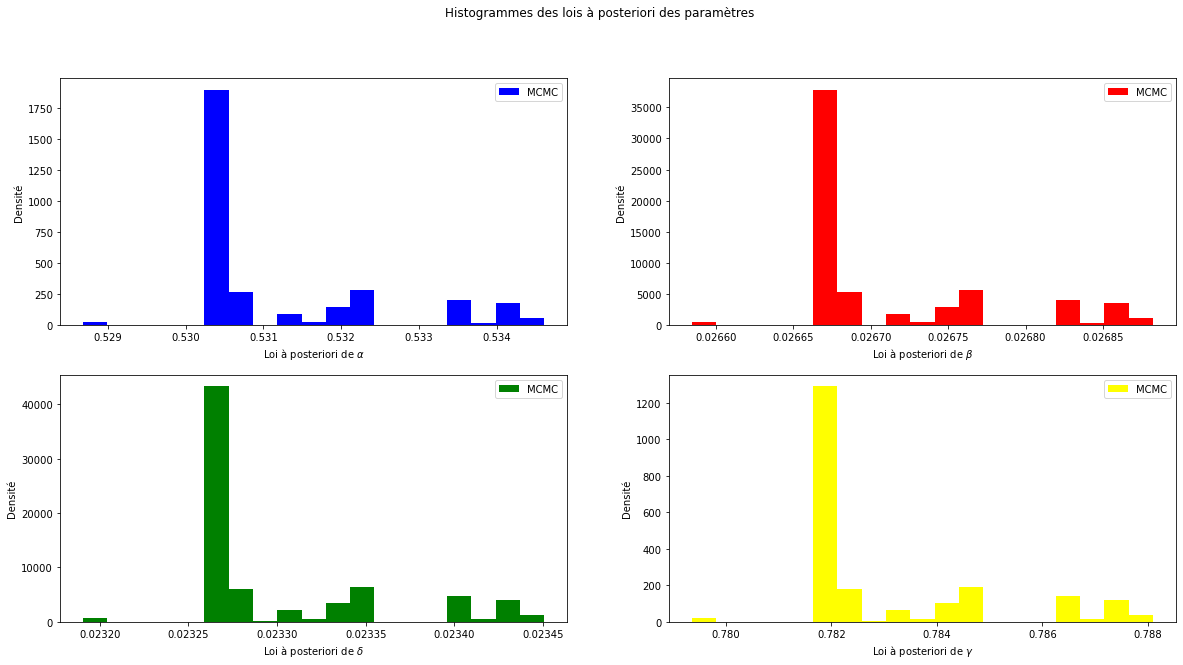

In [24]:
# On a convergence à peu près à partir de 700
burn = 700
echantillon = echantillon_x_sigma[burn:,:]
plt.figure(figsize=(20,10))
plt.suptitle("Histogrammes des lois à posteriori des paramètres")
for j in range(1, 5):
    plt.subplot(2, 2, j)
    plt.ylabel("Densité")
    plt.xlabel(f"Loi à posteriori de {params[j-1]}")
    n, bins, patches = plt.hist(echantillon[:, j-1], bins='auto', density=True, color=colors[j-1], label='MCMC')
    plt.legend(loc='best')

In [25]:
# Prédictions des populations de proies et prédateurs en 1921 et en 1930
# Simulation epsilon

# Calcul des prédiction pour les instants dans la listes dates
def prediction(dates):
    shape_echantillon = echantillon.shape[0]
    x = [echantillon[:,i] for i in range(6)]
    sigma = np.array([echantillon[:,i] for i in range(6,8)])
    #eps_proie = np.random.normal(0, sigma[0].reshape(shape_echantillon, 1), size=(shape_echantillon,len(dates)))
    #eps_preda = np.random.normal(0, sigma[1].reshape(shape_echantillon, 1), size=(shape_echantillon,len(dates)))
    eps_proie = np.random.normal(0, 0.21, size=(shape_echantillon,len(dates)))
    eps_preda = np.random.normal(0, 0.22, size=(shape_echantillon,len(dates)))

    y, z, _ = lotka_volterra_opt(x, dt = 0.001, tf = 1920, sample_size=2000)
    y = np.array(y[-1])
    z = np.array(z[-1])
    
    return y[np.array(dates)-t0]*np.exp(eps_proie), z[np.array(dates)-t0]*np.exp(eps_preda)

dates = [1921, 1930]
proie, preda =  prediction(dates)


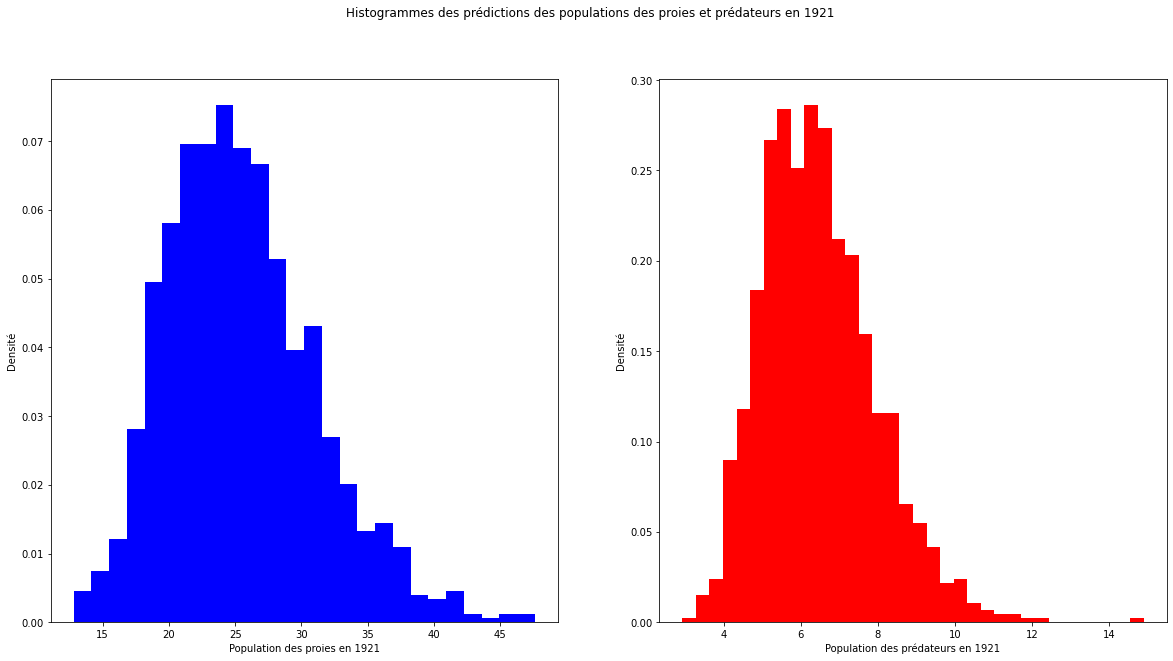

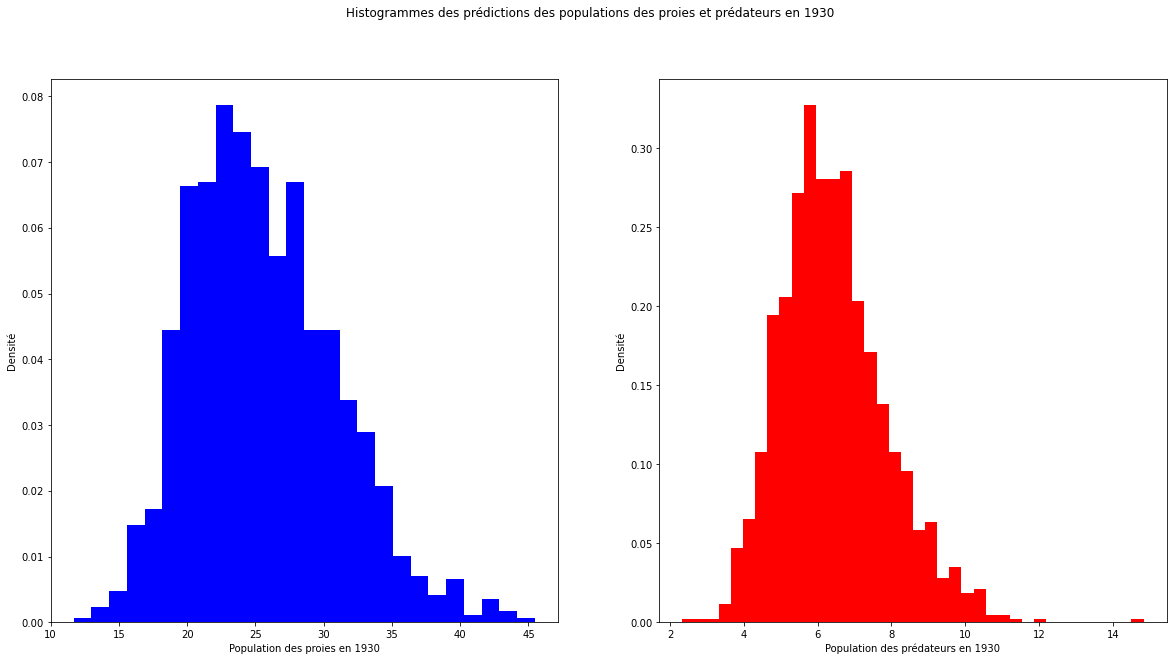

In [26]:
# Histogrammes 
#1921
plt.figure(figsize=(20,10))
plt.suptitle("Histogrammes des prédictions des populations des proies et prédateurs en 1921")
plt.subplot(1, 2, 1)
plt.ylabel("Densité")
plt.xlabel(f"Population des proies en 1921")
n, bins, patches = plt.hist(proie[:, 0], bins='auto', density=True, color='blue')
plt.subplot(1, 2, 2)
plt.ylabel("Densité")
plt.xlabel(f"Population des prédateurs en 1921")
n, bins, patches = plt.hist(preda[:, 0], bins='auto', density=True, color='red')

# 1930
plt.figure(figsize=(20,10))
plt.suptitle("Histogrammes des prédictions des populations des proies et prédateurs en 1930")
plt.subplot(1, 2, 1)
plt.ylabel("Densité")
plt.xlabel(f"Population des proies en 1930")
n, bins, patches = plt.hist(proie[:, 1], bins='auto', density=True, color='blue')
plt.subplot(1, 2, 2)
plt.ylabel("Densité")
plt.xlabel(f"Population des prédateurs en 1930")
n, bins, patches = plt.hist(preda[:, 1], bins='auto', density=True, color='red')